In [1]:
import os
from typing import *

import multiprocess as mp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import edgedroid.data as e_data
from edgedroid.models import *
from collections import deque


def process_model(
        mcls: Type[ExecutionTimeModel],
        run_id: int,
        # df: pd.DataFrame,
        # data: pd.DataFrame,
        fade_dist: int,
        samples: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    result = deque()

    # load the data
    params = e_data.load_default_exec_time_data()
    data = preprocess_data(*params, transition_fade_distance=fade_dist)
    raw_data, *_ = params

    # dataframe for participant
    df = raw_data[raw_data["run_id"] == run_id].copy()

    # prepare the model
    neuro = raw_data.iloc[0, df.columns.get_loc("neuroticism")]
    model: ExecutionTimeModel = mcls(data=data, neuroticism=neuro, transition_fade_distance=fade_dist)

    # record task duration
    task_df = pd.DataFrame(index=np.arange(samples), columns=["run_id", "real_task_duration", "model_task_duration"])
    task_df["run_id"] = run_id
    task_df["real_task_duration"] = df["exec_time"].sum()
    task_df["model"] = mcls.__name__

    for i in range(samples):
        model.reset()
        states = deque()

        model_exec_times = np.empty(len(df.index), dtype=np.float64)

        for j, step in enumerate(df.itertuples(index=True)):
            model_exec_times[j] = model.get_execution_time()
            states.append(model.state_info())
            model.set_delay(step.delay)

        result_df = df.copy()
        result_df["model_exec_time"] = model_exec_times
        result_df["sample"] = i
        result_df["model"] = mcls.__name__

        model_df = pd.DataFrame(states)
        result_df = result_df.merge(
            right=model_df.drop(columns=["neuroticism_raw"]),
            on="seq",
            suffixes=["", "_model"]
        )

        result.append(result_df)
        task_df.at[i, "model_task_duration"] = result_df["model_exec_time"].sum()

    trace_df = pd.concat(result, ignore_index=True)
    del result

    task_df["reldiff"] = (task_df["model_task_duration"] - task_df["real_task_duration"]) / task_df["real_task_duration"]
    task_df["fade_distance"] = fade_dist

    # filter outliers using preprocessed data
    # remove the top and bottom 5-percentiles (exec times)
    for _, df in data.groupby(["neuroticism", "impairment", "transition", "duration"]):
        # winsorize
        percs = np.percentile(df.next_exec_time, [5, 95])

        out = df[(df["next_exec_time"] < percs[0]) | (df["next_exec_time"] > percs[1])]
        trace_df = trace_df[~(np.isin(trace_df["run_id"], out["run_id"]) & np.isin(trace_df["seq"], out["seq"]))]

    trace_df = trace_df.copy()
    trace_df["reldiff"] = (trace_df["model_exec_time"] - trace_df["exec_time"]) / trace_df["exec_time"]
    trace_df["fade_distance"] = fade_dist

    return trace_df, task_df


samples = 50

raw_data, *_ = e_data.load_default_exec_time_data()
run_ids = raw_data.run_id.unique()
del raw_data

step_result = deque()
task_result = deque()
workers = os.cpu_count() - 1
for mcls in tqdm((TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel), leave=True, desc="Models"):
    for i, fade_dist in enumerate(tqdm((2, 4, 8, None), leave=True, desc="Fade distance")):
        with tqdm(total=len(run_ids), leave=True, desc="Runs", position=i) as pbar, mp.Pool(workers) as pool:
            fade_result = [
                pool.apply_async(
                    process_model,
                    args=(
                        mcls,
                        rid,
                        fade_dist,
                        samples
                    ),
                    callback=lambda _: pbar.update()
                )
                for rid in run_ids
            ]

            for r in fade_result:
                step_df, task_df = r.get()
                step_result.append(step_df)
                task_result.append(task_df)

            # step_result.extend([r.get() for r in fade_result])

trace_result = pd.concat(step_result, ignore_index=True)
trace_task_result = pd.concat(task_result, ignore_index=True)
del step_result
del task_result

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Fade distance:   0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Fade distance:   0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

In [2]:
trace_result["fade_distance"] = trace_result["fade_distance"].replace({None: -1})
trace_result

,run_id,seq,exec_time,delay,neuroticism,model_exec_time,sample,model,neuroticism_model,delay_model,impairment,transition,duration,duration_raw,reldiff,fade_distance
0,134146,21,3.909,3.000,0.375,3.041430,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",3.000,"[2.0, inf)",NoTransition,"[5.0, 10.0)",6,-0.221942,2
1,134146,30,5.421,2.700,0.375,3.169294,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.700,"[2.0, inf)",NoTransition,"[10.0, inf)",15,-0.415367,2
2,134146,35,3.392,2.700,0.375,3.217750,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.700,"[2.0, inf)",NoTransition,"[10.0, inf)",20,-0.051371,2
3,134146,56,3.556,1.650,0.375,5.464406,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",1.650,"[1.0, 2.0)",NoTransition,"[10.0, inf)",17,0.536672,2
4,134146,57,7.458,0.000,0.375,3.199299,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",1.650,"[1.0, 2.0)",NoTransition,"[10.0, inf)",18,-0.571024,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934295,137353,125,7.748,1.650,0.625,2.909400,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",1.125,"[1.0, 2.0)",Higher2Lower,"[10.0, inf)",12,-0.624497,-1
934296,137353,139,8.639,2.175,0.625,5.229000,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.175,"[2.0, inf)",Lower2Higher,"[0.0, 5.0)",2,-0.394722,-1
934297,137353,145,5.381,2.175,0.625,7.359000,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.175,"[2.0, inf)",Lower2Higher,"[5.0, 10.0)",8,0.367590,-1
934298,137353,154,8.614,3.000,0.625,11.781200,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",3.000,"[2.0, inf)",Lower2Higher,"[0.0, 5.0)",1,0.367681,-1


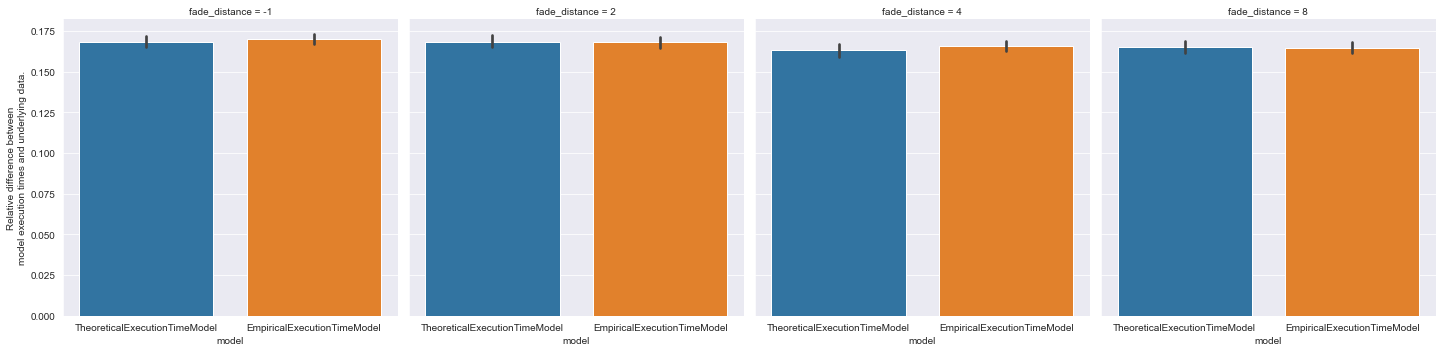

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fg = sns.catplot(
    kind="bar",
    x="model",
    y="reldiff",
    col="fade_distance",
    data=trace_result,
    ci=95
)
fg.set_ylabels("Relative difference between\nmodel execution times and underlying data.")
plt.show()

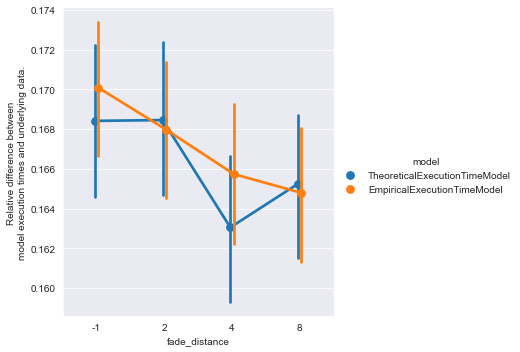

In [4]:
fg = sns.catplot(
    kind="point",
    x="fade_distance",
    y="reldiff",
    hue="model",
    data=trace_result,
    ci=95,
    dodge=True,
    # err_style="bars",
)
fg.set_ylabels("Relative difference between\nmodel execution times and underlying data.")
plt.show()

In [5]:
trace_result.groupby(["model", "fade_distance"])["reldiff"].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, .9, .99])

count      mean       std  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1             114250.0  0.170083  0.590672   
                               2             115250.0  0.167978  0.597231   
                               4             114350.0  0.165737  0.596021   
                               8             123300.0  0.164791  0.598649   
TheoreticalExecutionTimeModel -1             114250.0  0.168413  0.658329   
                               2             115250.0  0.168454  0.655654   
                               4             114350.0  0.163050  0.661472   
                               8             123300.0  0.165249  0.662003   

                                                  min        5%       10%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1            -0.759572 -0.531912 -0.446948   
                               2            -0.796435 -0.535348 -0.452568   
                               4            -0.767412 -0.535546 -0.454471   
                               8            -0.785485 -0.540334 -0.455359   
TheoreticalExecutionTimeModel -1            -1.000000 -0.544354 -0.459925   
                               2            -1.000000 -0.542084 -0.455717   
                               4            -1.000000 -0.547578 -0.464681   
                               8            -0.942790 -0.545036 -0.462507   

                                                  25%       50%       75%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1            -0.259917  0.037317  0.461026   
                               2            -0.264717  0.030839  0.457287   
                               4            -0.267069  0.032095  0.455139   
                               8            -0.268151  0.025949  0.454976   
TheoreticalExecutionTimeModel -1            -0.276727  0.011267  0.429962   
                               2            -0.275305  0.011275  0.429865   
                               4            -0.284138  0.003372  0.426278   
                               8            -0.279983  0.006398  0.425028   

                                                  90%       99%        max  
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1             0.969159  2.084270   4.547062  
                               2             0.969401  2.119515   4.286528  
                               4             0.965006  2.106115   4.571429  
                               8             0.969394  2.152759   4.876651  
TheoreticalExecutionTimeModel -1             0.975228  2.506082  10.808833  
                               2             0.975226  2.485803  11.023363  
                               4             0.973588  2.524247  10.039331  
                               8             0.971791  2.541037  10.159990

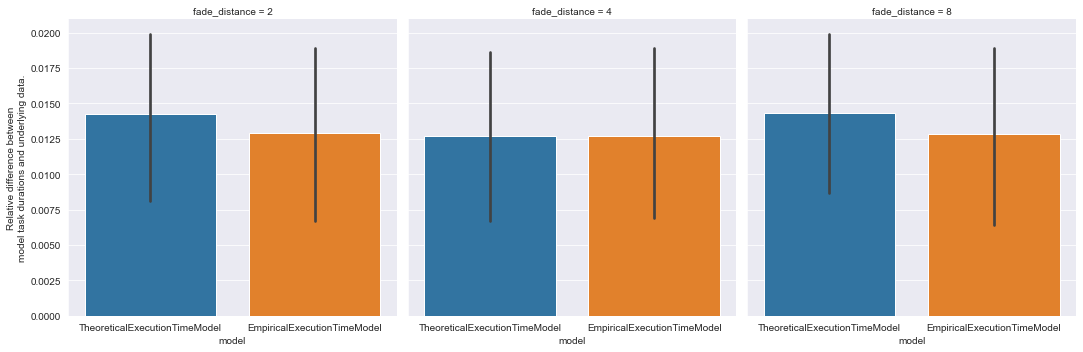

In [6]:
fg = sns.catplot(
    kind="bar",
    x="model",
    col="fade_distance",
    y="reldiff",
    data=trace_task_result,
    ci=95,
)
fg.set_ylabels("Relative difference between\nmodel task durations and underlying data.")
plt.show()

In [7]:
trace_task_result["reldiff"] = trace_task_result["reldiff"].astype(float)
trace_task_result.groupby(["model", "fade_distance"])["reldiff"].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, .9, .99])

count      mean       std  \
model                         fade_distance                               
EmpiricalExecutionTimeModel   2              2000.0  0.012907  0.139523   
                              4              2000.0  0.012703  0.137631   
                              8              2000.0  0.012815  0.138244   
TheoreticalExecutionTimeModel 2              2000.0  0.014260  0.138930   
                              4              2000.0  0.012731  0.138360   
                              8              2000.0  0.014299  0.138626   

                                                  min        5%       10%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   2             -0.279771 -0.201231 -0.168906   
                              4             -0.266766 -0.200994 -0.169877   
                              8             -0.271396 -0.202983 -0.170661   
TheoreticalExecutionTimeModel 2             -0.278588 -0.200699 -0.173562   
                              4             -0.291840 -0.201673 -0.174018   
                              8             -0.286163 -0.199760 -0.174471   

                                                  25%       50%       75%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   2             -0.099251  0.006073  0.117574   
                              4             -0.099571  0.008672  0.110548   
                              8             -0.097222  0.007658  0.113419   
TheoreticalExecutionTimeModel 2             -0.095126  0.010120  0.113627   
                              4             -0.096300  0.008356  0.112428   
                              8             -0.095225  0.008919  0.112811   

                                                  90%       99%       max  
model                         fade_distance                                
EmpiricalExecutionTimeModel   2              0.211880  0.308857  0.415053  
                              4              0.214015  0.296720  0.347094  
                              8              0.212911  0.301611  0.348699  
TheoreticalExecutionTimeModel 2              0.214359  0.300671  0.406335  
                              4              0.213814  0.301427  0.388241  
                              8              0.214298  0.306236  0.395873

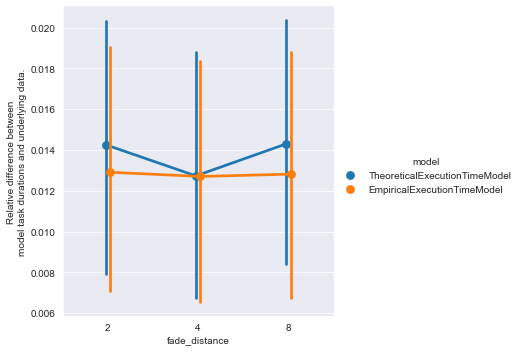

In [8]:
fg = sns.catplot(
    kind="point",
    hue="model",
    x="fade_distance",
    y="reldiff",
    data=trace_task_result,
    ci=95,
    dodge=True,
)
fg.set_ylabels("Relative difference between\nmodel task durations and underlying data.")
plt.show()